In [190]:
from model import CondInvicuna

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
from viz import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
config = {'num_bijectors': 6,
          'bijector': 'RealNVP',
          'network_size': 64,
          'use_batchnorm': True,
          'y_dim': 2,
          'x_dim': 1,
          'nn_layers': [64,64,32],
          'activation': 'tanh',
          'sigma_eps': 0.01,
          'batch_size': 20,
          'data_horizon': 2,
          'test_horizon': 50,
          'learning_rate': 1e-4}

In [272]:
class MultistepDataset:
    def __init__(self, aux_dim=0, noise_var=0.001, rng=None):
        self.step_min = -3.
        self.step_max = 3.
        self.num_steps = 3
        self.x_range = [-5.,5.]
        self.noise_std = np.sqrt( noise_var )
        
        self.x_dim = 1
        self.aux_dim = aux_dim
        self.y_dim = 1 + aux_dim
            
        self.np_random = rng
        if rng is None:
            self.np_random = np.random
            
    def sample(self, n_funcs, n_samples, return_lists=False):
        x = np.zeros((n_funcs, n_samples, self.x_dim))
        y = np.zeros((n_funcs, n_samples, self.y_dim))
        
        step_mat = np.zeros((n_funcs, self.num_steps))
        
        for i in range(n_funcs):
            step_pts = self.step_min + self.np_random.rand(self.num_steps)* (self.step_max - self.step_min)
            step_mat[i,:] = step_pts
            
            x_samp = self.x_range[0] + self.np_random.rand(n_samples)*(self.x_range[1] - self.x_range[0])
            y_samp = self.multistep(x_samp, step_pts)

            x[i,:,0] = x_samp
            y[i,:,0] = y_samp
            y[i,:,1:] = self.np_random.randn(n_samples, self.aux_dim)

        if return_lists:
            return x,y,step_mat

        return x,y
    
    def multistep(self, x, step_pts):
        x = x.reshape([1,-1])
        step_pts = step_pts.reshape([-1,1])
        y = 2.*np.logical_xor.reduce( x > step_pts, axis=0) - 1.
        y += self.noise_std*self.np_random.randn(x.shape[1])
        return y

In [2]:
g1 = tf.Graph()
sess1 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g1)

NameError: name 'tf' is not defined

In [3]:
model = CondInvicuna(sess1, config)
model.construct_model()

NameError: name 'CondInvicuna' is not defined

In [275]:
dataset = MultistepDataset(1)

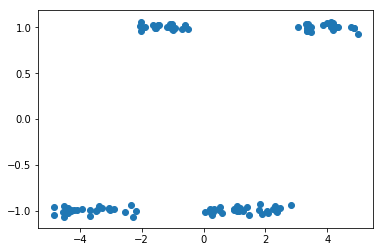

In [266]:
xx,yy = dataset.sample(10,100)
for j in range(1):
    plt.scatter(xx[j,:,0],yy[j,:,0])
plt.savefig('cond_meta_sample.pdf')
plt.show()

In [276]:
model.train(dataset,5000)

itr: 0 ; loss: 47.701
itr: 20 ; loss: 34.367653
itr: 40 ; loss: 28.021791
itr: 60 ; loss: 27.375328
itr: 80 ; loss: 24.206203
itr: 100 ; loss: 21.520227
itr: 120 ; loss: 18.791142
itr: 140 ; loss: 18.583504
itr: 160 ; loss: 13.318937
itr: 180 ; loss: 12.403699
itr: 200 ; loss: 11.578682
itr: 220 ; loss: 9.986037
itr: 240 ; loss: 11.96894
itr: 260 ; loss: 9.776339
itr: 280 ; loss: 8.535715
itr: 300 ; loss: 9.679526
itr: 320 ; loss: 7.8957944
itr: 340 ; loss: 8.341338
itr: 360 ; loss: 7.1517687
itr: 380 ; loss: 6.8418026
itr: 400 ; loss: 7.278545
itr: 420 ; loss: 5.8771143
itr: 440 ; loss: 5.745587
itr: 460 ; loss: 5.3953557
itr: 480 ; loss: 4.998909
itr: 500 ; loss: 3.979914
itr: 520 ; loss: 4.5463085
itr: 540 ; loss: 4.8634615
itr: 560 ; loss: 3.9695115
itr: 580 ; loss: 3.9827433
itr: 600 ; loss: 3.877317
itr: 620 ; loss: 3.9006705
itr: 640 ; loss: 3.3732414
itr: 660 ; loss: 3.824816
itr: 680 ; loss: 3.4370737
itr: 700 ; loss: 3.2241206
itr: 720 ; loss: 3.1183035
itr: 740 ; loss: 3.064

In [277]:
x_q = np.linspace(-5,5,50).reshape([1,-1,1])
x_t,y_t = dataset.sample(1,50)

n_samples = 10
n_context = 4

#print(x_t[:,:n_context,:].shape)
# y_sample = model.gen_samples(x_t[:,:n_context,:],y_t[:,:n_context,:],x_q,n_samples)

In [37]:
xx = x_t.reshape([-1, 1])
yy = y_t[:,:,0].reshape([-1,1])

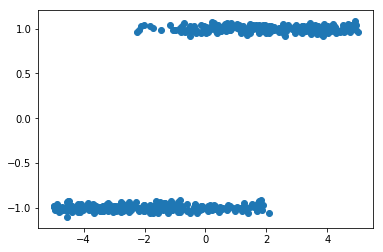

In [38]:
plt.scatter(xx,yy)

In [386]:
print(y_sample.shape)

(10, 1, 50, 11)


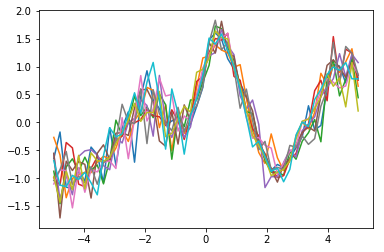

In [395]:
for i in range(n_samples):
    plt.plot(x_q[0,:,0],y_sample[i,0,:,0])
plt.show()

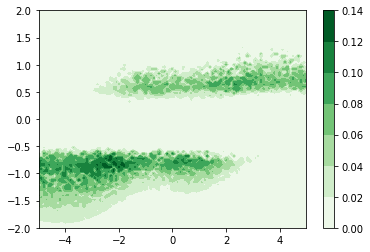

In [280]:
plot_conditional_likelihood(model, x_t[:,:0,:],y_t[:,:0,:], num_aux=1)
#plt.savefig('conditional_prior_noflow.pdf')
plt.show()

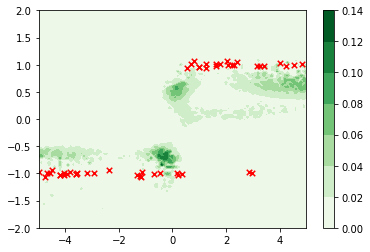

In [281]:
plot_conditional_likelihood(model, x_t[:,:50,:],y_t[:,:50,:], num_aux=1)
#plt.savefig('conditional_posterior_noflow.pdf')
plt.show()